# Import libs

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [4]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import torchvision
from skimage import io, transform
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import time
import os
import copy
import pandas as pd
from sklearn.model_selection import train_test_split
from PIL import Image


plt.ion()   # interactive mode

use_gpu = torch.cuda.is_available()
if use_gpu:
    torch.cuda.set_device(0)

# Load data

In [5]:
class CsvDataset(Dataset):
    def __init__(self, label_df, root_dir, transform=None):
        self.label_frame = label_df
        self.root_dir = root_dir
        self.transform = transform
        self.classes = list(self.label_frame.breed.unique())
        self.class_indexes = {self.classes[i]: i for i in range(0, len(self.classes))}

    def __len__(self):
        return len(self.label_frame) - 1

    def __getitem__(self, idx):
        label = self.label_frame.iloc[idx, 1]
        img_path = os.path.join(self.root_dir, self.label_frame.iloc[idx, 0] + '.jpg')
        image = Image.open(img_path)

        if self.transform:
            image = self.transform(image)

        return image, self.class_indexes[label]

In [21]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}


data_dir = './data/dogbreeds'
label_csv = 'labels.csv'
label_df = pd.read_csv(f'{data_dir}/{label_csv}')

train, val = train_test_split(label_df, test_size=0.2)
image_datasets = {'train': CsvDataset(train, f'{data_dir}/train', data_transforms['train']),
                 'val': CsvDataset(val, f'{data_dir}/train', data_transforms['val'])}


dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=128, shuffle=True, num_workers=4)
                  for x in ['train', 'val']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}


class_names = image_datasets['train'].classes

# View images

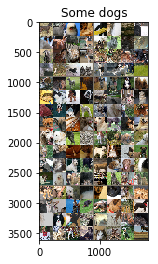

In [22]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title='Some dogs')

# Train the model

In [23]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train(True)  # Set model to training mode
            else:
                model.train(False)  # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for data in dataloaders[phase]:
                # get the inputs
                inputs, labels = data

                if use_gpu:
                    inputs = Variable(inputs.cuda())
                    labels = Variable(labels.cuda())
                else:
                    inputs, labels = Variable(inputs), Variable(labels)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                outputs = model(inputs)
                _, preds = torch.max(outputs.data, 1)
                loss = criterion(outputs, labels)

                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                # statistics
                running_loss += loss.data[0] * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

## Visualize Model

In [24]:
def visualize_model(model, num_images=6):
    images_so_far = 0
    fig = plt.figure()

    for i, data in enumerate(dataloaders['val']):
        inputs, labels = data
        if use_gpu:
            inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
        else:
            inputs, labels = Variable(inputs), Variable(labels)

        outputs = model(inputs)
        _, preds = torch.max(outputs.data, 1)

        for j in range(inputs.size()[0]):
            images_so_far += 1
            ax = plt.subplot(num_images//2, 2, images_so_far)
            ax.axis('off')
            ax.set_title('predicted: {}'.format(class_names[preds[j]]))
            imshow(inputs.cpu().data[j])

            if images_so_far == num_images:
                return

## Build Model

In [25]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, len(class_names))

if use_gpu:
    model_ft = model_ft.cuda()

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [26]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 4.7305 Acc: 0.0296


Process Process-27:
Process Process-26:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Process Process-28:
  File "/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 50, in _worker_loop
    r = index_queue.get()
  File "/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/multiprocessing/process.py", line 258, in _boot

KeyboardInterrupt: 